# CG for Poisson problem
## Numerical experiments for the conditioning

Consider the Posson problem on $\Omega\subseteq\mathbb R^{d}$, $d=2,3$.

\begin{equation*}
\begin{array}{rclll}
-\Delta u &=& f&\mbox{in}&\Omega \\
u &=& u_D& \mbox{on}& \partial \Omega
\end{array}
\end{equation*}

In [135]:
from ngsolve import *
from netgen.geom2d import unit_square 
from ngsolve.webgui import Draw 
from ngsolve.la import EigenValues_Preconditioner
import scipy.sparse as sp
from scipy.sparse.linalg import eigs, eigsh
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
import pandas as pd

In [116]:
# Data
force2d = ((2*pi**2))*sin(pi*x)*sin(pi*y)
uD    = 0        
dirichlet_boundary2d = 'left|bottom|right|top'

In [117]:
# Fix h
h = .25
mesh2d = Mesh(unit_square.GenerateMesh(maxh=h))
# print(mesh.GetBoundaries())
# Draw(mesh)

In [122]:
def SetUp_CG(mesh,p, db, condense=False):
    fes = H1(mesh, order=p, dirichlet=db)
    u, v = fes.TnT()
    # Bilinear form
    a = BilinearForm(fes, condense=condense)
    a += (grad(u)*grad(v))*dx
    a.Assemble();
    return a, fes

def SolvePoisson_CG(mesh, p, force, uD, db): # Dirichlet boundary conditions
    a, fes = SetUp_CG(mesh, p, db, condense=False)
    f = LinearForm(fes)
    f += (force*v)*dx
    f.Assemble()
    gf = GridFunction(fes)
    gf.Set(uD, BND)
    r = f.vec.CreateVector()
    r.data = f.vec - a.mat * gf.vec
    inv = a.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data += inv * r
    
    return gf

In [123]:
gfu = SolvePoisson_CG(mesh2d, p=5,force=force2d, uD=uD, db=dirichlet_boundary2d)
# Draw(gfu)

## Condition number

In [124]:
def get_kappa(mesh,p, db, condense):
    a, fes=SetUp_CG(mesh, p, db, condense)
    # sparse scipy matrix
    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    # restrict to freedof
    fd = list(fes.FreeDofs(condense))
    Afree = A[fd,:][:,fd]
    # Estimate condition number kappa
    lams_LM = eigsh(Afree, which='LM')[0]
    lams_SM = eigsh(Afree, which='SM')[0]
    lams = np.concatenate((lams_LM, lams_SM))
    kappa = max(lams)/min(lams)
    return kappa

In [130]:
def test_condition_number_fixmesh(mesh, db, condense=False, pmax=6):
    kappa=[]
    p = [i for i in range(2,pmax)]
    for pi in p:
        kappa.append(get_kappa(mesh, pi, db, condense))
    return p, kappa

In [138]:
# p, kappa= test_condition_number_fixmesh(mesh,dirichlet_boundary,condense=False, pmax=10)
p_sc, kappa_sc = test_condition_number_fixmesh(mesh2d, dirichlet_boundary2d, condense=True, pmax=15)

In [139]:
# print(p, kappa)
print(p_sc, kappa_sc)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] [239.0494491002373, 618.8479574694824, 1314.2335598521643, 2385.260208716912, 3931.8154705458146, 6044.727960820038, 8788.86431635111, 12273.41512274128, 16560.203612295125, 21756.573246774253, 27928.871935320276, 35179.723072807385, 43579.895898558985]


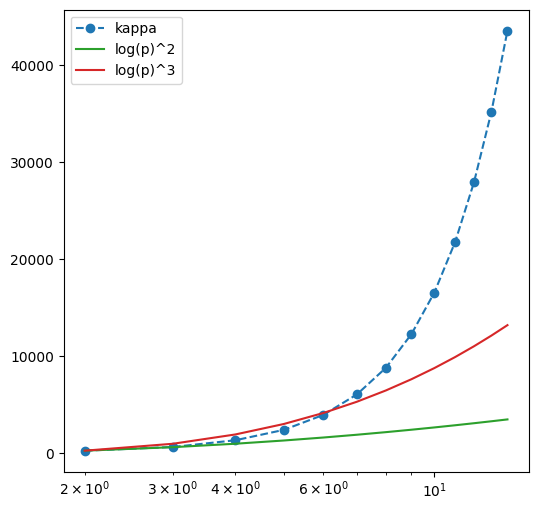

In [142]:
def plots_cond_number(p, kappa):
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.semilogx(p, kappa,'--o',label='kappa')
    
    C2 = kappa[0]/(np.log(p[0])*np.log(p[0]))
    p2 = [C2*np.log(p_i)*np.log(p_i) for p_i in p]
    ax.semilogx(p, p2,'C02', label='log(p)^2')

    C3 = kappa[0]/(np.log(p[0])*np.log(p[0])*np.log(p[0]))
    p3 = [C3*np.log(p_i)*np.log(p_i)*np.log(p_i) for p_i in p]
    ax.semilogx(p, p3,'C03', label='log(p)^3')
    ax.legend()
#     plt.savefig('kappa_HDG_2d.png')
    plt.show()
def compute_gamma(kappa, p):
    gamma = ['-']
    for i in range(len(p)-1):
#         gamma.append(np.log(kappa[i+1]/kappa[i])/np.log(np.log(p[i+1])/np.log(p[i])))
        gamma.append(np.log(kappa[i+1]/kappa[i])/np.log(p[i+1]/p[i]))
    return gamma
gamma2d = compute_gamma(kappa_sc, p_sc)
df_2d = pd.DataFrame({'p':p_sc, 'kappa':kappa_sc, 'log(p)':np.log(p_sc), 'gamma':gamma2d})
# print(gamma2d)
plots_cond_number(p_sc, kappa_sc)

In [143]:
df_2d


,p,kappa,log(p),gamma
0,2,239.049449,0.693147,-
1,3,618.847957,1.098612,2.345921
2,4,1314.233560,1.386294,2.617992
3,5,2385.260209,1.609438,2.671171
4,6,3931.815471,1.791759,2.741272
5,7,6044.727961,1.945910,2.790031
6,8,8788.864316,2.079442,2.803079
7,9,12273.415123,2.197225,2.835298
8,10,16560.203612,2.302585,2.843256
9,11,21756.573247,2.397895,2.863424


# 3D case

In [144]:
from netgen.csg import *

In [145]:
# Data
force3d = ((3*pi**2))*sin(pi*x)*sin(pi*y)*sin(pi*z)
uD    = 0        
dirichlet_boundary3d = 'back|left|front|right|bottom|top'

In [146]:
# Fix h
h = 0.5
mesh3d = Mesh(unit_cube.GenerateMesh(maxh=h))
# print(mesh.GetBoundaries())
# Draw(mesh)

In [148]:
gfu = SolvePoisson_CG(mesh3d, p=5,force=force3d, uD=uD, db=dirichlet_boundary3d)
# Draw(gfu)

In [151]:
p_sc_3d, kappa_sc_3d = test_condition_number_fixmesh(mesh3d, dirichlet_boundary3d, condense=True, pmax=7)

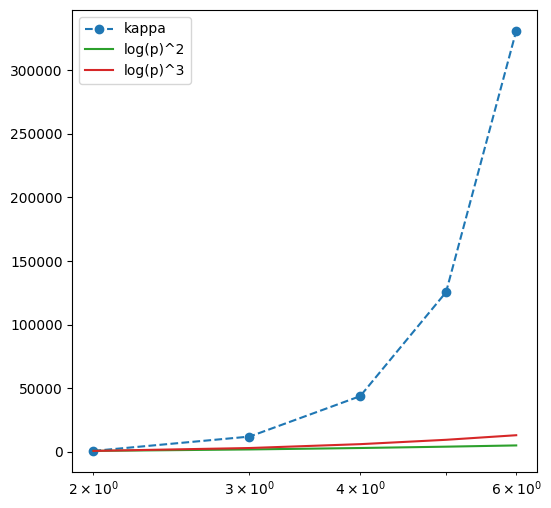

,p,kappa,log(p),gamma
0,2,757.030455,0.693147,-
1,3,11995.605864,1.098612,6.814131
2,4,43763.955949,1.386294,4.49896
3,5,125452.745863,1.609438,4.719467
4,6,330717.589383,1.791759,5.316627


In [152]:
gamma3d = compute_gamma(kappa_sc_3d, p_sc_3d)
df_3d = pd.DataFrame({'p':p_sc_3d, 'kappa':kappa_sc_3d, 'log(p)':np.log(p_sc_3d), 'gamma':gamma3d})
plots_cond_number(p_sc_3d, kappa_sc_3d)

df_3d